In [73]:
import pandas as pd

df = pd.read_csv('raw_training_df.csv')
df.set_index('genes', inplace=True)
df = df.T

metadata = pd.read_csv('metadata.csv')
metadata = metadata.set_index('sample_id')

In [74]:
bio_tag = 'cell_type'
batch_tag = 'prep_method_broad'

In [75]:
import scanpy as sc

adata = sc.AnnData(df)
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True, how='left')

In [76]:
adata.obs

,dataset_id,cell_type,parental_cell_type,final_cell_type,disease_state,organism,sample_type,tissue_of_origin,sample_name_long,media,...,prep_method_broad,preparation_method,capture,fragmentation,stranded,sequencing_layout,average_read_length,sequencer,training_atlas,sample_id_without_datasetid
1611_GSM2027310,1611,conventional dendritic cell,NaN,NaN,normal,homo sapiens,cDC2,blood,blood conventional dendritic cell type two (CD...,NaN,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027310
1611_GSM2027311,1611,conventional dendritic cell,NaN,NaN,normal,homo sapiens,cDC1,blood,blood conventional dendritic cell type one (CD...,NaN,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027311
1611_GSM2027312,1611,plasmacytoid dendritic cell,NaN,NaN,normal,homo sapiens,pDC,blood,blood plasmacytoid dendritic cell (CD2-negative),NaN,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027312
1611_GSM2027313,1611,plasmacytoid dendritic cell,NaN,NaN,normal,homo sapiens,pDC,blood,blood plasmacytoid dendritic cell (CD2-positive),NaN,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,50,Illumina HiSeq 2000,include,GSM2027313
1611_GSM2027314,1611,conventional dendritic cell,NaN,NaN,normal,homo sapiens,cDC2,blood,blood conventional dendritic cell type two (CD...,NaN,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9798_Kolf2_iMacs_UT_16h_2_01,9798,macrophage,induced pluripotent stem cell,macrophage,normal,homo sapiens,UT_16h,NaN,induced pluripotent stem cell derived macropha...,TBC,...,hudson,Hudson,unknown,unknown,unknown,unknown,unknown,unknown,include,Kolf2
9798_Kolf2_iMacs_UT_16h_3_01,9798,macrophage,induced pluripotent stem cell,macrophage,normal,homo sapiens,UT_16h,NaN,induced pluripotent stem cell derived macropha...,TBC,...,hudson,Hudson,unknown,unknown,unknown,unknown,unknown,unknown,include,Kolf2
9798_Kolf2_iMacs_UT_6h_1_01,9798,macrophage,induced pluripotent stem cell,macrophage,normal,homo sapiens,UT_6h,NaN,induced pluripotent stem cell derived macropha...,TBC,...,hudson,Hudson,unknown,unknown,unknown,unknown,unknown,unknown,include,Kolf2
9798_Kolf2_iMacs_UT_6h_2_01,9798,macrophage,induced pluripotent stem cell,macrophage,normal,homo sapiens,UT_6h,NaN,induced pluripotent stem cell derived macropha...,TBC,...,hudson,Hudson,unknown,unknown,unknown,unknown,unknown,unknown,include,Kolf2


In [77]:
from scib_metrics.benchmark import Benchmarker

In [78]:
import torch
device = 'gpu' if torch.cuda.is_available() else 'cpu'
device

'gpu'

In [79]:
import scvi

# Set up the AnnData object
scvi.model.SCVI.setup_anndata(adata, batch_key=batch_tag, labels_key = 'cell_type')

# Parameters
n_runs = 20  # Number of models to train
overall_score = 0

for i in range(n_runs):
    print(f"\nTraining model run {i+1}/{n_runs}\n")

    # Initialize the SCVI model
    # model = scvi.model.SCVI(adata, n_hidden=64, n_layers=4, n_latent=3, gene_likelihood="zinb")
    model = scvi.model.SCVI(
        adata,
        n_hidden=256, n_layers=4, n_latent=3, gene_likelihood="nb",
        dropout_rate = 0.1, latent_distribution = 'norm', dispersion = 'gene-cell'
    )
    # Train the model with reproducibility
    model.train(
        plan_kwargs={'lr': 0.002670226895111946},
        accelerator=device,
        max_epochs=300,
        early_stopping=True
    )

    # Get latent representation
    adata.obsm[f'X_scVI_run_{i+1}'] = model.get_latent_representation()

    bm = Benchmarker(
        adata,
        batch_key=batch_tag,
        label_key=bio_tag,
        embedding_obsm_keys=[f'X_scVI_run_{i+1}']
    )
    bm.benchmark()

    current_overall_score = bm.get_results(min_max_scale=False)['Total'][f'X_scVI_run_{i+1}']
    print(f"\nThis model's overall score: {current_overall_score}")

    if current_overall_score>overall_score:
      print("\nNew best model found!")
      best_model = model
      overall_score = current_overall_score



Training model run 1/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 139/300:  46%|████▋     | 139/300 [00:06<00:08, 20.07it/s, v_num=1, train_loss_step=1.16e+5, train_loss_epoch=1.15e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 118655.883. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



This model's overall score: 0.6117555354237803

New best model found!

Training model run 2/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 190/300:  63%|██████▎   | 190/300 [00:09<00:05, 20.82it/s, v_num=1, train_loss_step=1.14e+5, train_loss_epoch=1.14e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 121694.648. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be remov


This model's overall score: 0.5826732480223311

Training model run 3/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 211/300:  70%|███████   | 211/300 [00:10<00:04, 19.20it/s, v_num=1, train_loss_step=1.09e+5, train_loss_epoch=1.13e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 123367.828. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be remov


This model's overall score: 0.6266877031317377

New best model found!

Training model run 4/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 232/300:  77%|███████▋  | 232/300 [00:11<00:03, 19.47it/s, v_num=1, train_loss_step=1.09e+5, train_loss_epoch=1.11e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 119412.633. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be remov


This model's overall score: 0.5920100463677648

Training model run 5/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 193/300:  64%|██████▍   | 193/300 [00:09<00:05, 20.08it/s, v_num=1, train_loss_step=1.14e+5, train_loss_epoch=1.13e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 119292.023. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



This model's overall score: 0.5920449176572735

Training model run 6/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 235/300:  78%|███████▊  | 235/300 [00:12<00:03, 19.05it/s, v_num=1, train_loss_step=1.15e+5, train_loss_epoch=1.11e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 119166.609. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



This model's overall score: 0.5887442812649574

Training model run 7/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 300/300: 100%|██████████| 300/300 [00:15<00:00, 19.64it/s, v_num=1, train_loss_step=1.09e+5, train_loss_epoch=1.1e+5] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [00:15<00:00, 19.71it/s, v_num=1, train_loss_step=1.09e+5, train_loss_epoch=1.1e+5]


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



This model's overall score: 0.6034578268235269

Training model run 8/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 126/300:  42%|████▏     | 126/300 [00:06<00:08, 19.56it/s, v_num=1, train_loss_step=1.18e+5, train_loss_epoch=1.16e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 123545.102. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]



This model's overall score: 0.6017752637924223

Training model run 9/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 225/300:  75%|███████▌  | 225/300 [00:11<00:03, 19.78it/s, v_num=1, train_loss_step=1.11e+5, train_loss_epoch=1.12e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 122467.164. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



This model's overall score: 0.5919542290207722

Training model run 10/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 100/300:  33%|███▎      | 100/300 [00:04<00:09, 20.27it/s, v_num=1, train_loss_step=1.15e+5, train_loss_epoch=1.15e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 138114.812. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



This model's overall score: 0.5835608640336034

Training model run 11/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 184/300:  61%|██████▏   | 184/300 [00:08<00:05, 20.91it/s, v_num=1, train_loss_step=1.14e+5, train_loss_epoch=1.13e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 124711.242. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]



This model's overall score: 0.558850070529765

Training model run 12/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 186/300:  62%|██████▏   | 186/300 [00:09<00:05, 20.41it/s, v_num=1, train_loss_step=1.17e+5, train_loss_epoch=1.13e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 117273.195. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]



This model's overall score: 0.6168705244246876

Training model run 13/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 174/300:  58%|█████▊    | 174/300 [00:09<00:06, 19.08it/s, v_num=1, train_loss_step=1.12e+5, train_loss_epoch=1.13e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 117421.203. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be remov


This model's overall score: 0.6075560526516197

Training model run 14/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 196/300:  65%|██████▌   | 196/300 [00:09<00:05, 20.17it/s, v_num=1, train_loss_step=1.13e+5, train_loss_epoch=1.13e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 122305.023. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



This model's overall score: 0.6005351049093458

Training model run 15/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 293/300:  98%|█████████▊| 293/300 [00:14<00:00, 20.53it/s, v_num=1, train_loss_step=1.1e+5, train_loss_epoch=1.11e+5] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 115878.945. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



This model's overall score: 0.6157104627229061

Training model run 16/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 191/300:  64%|██████▎   | 191/300 [00:09<00:05, 20.33it/s, v_num=1, train_loss_step=1.15e+5, train_loss_epoch=1.12e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 127426.977. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]



This model's overall score: 0.5869345516668781

Training model run 17/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 191/300:  64%|██████▎   | 191/300 [00:09<00:05, 19.81it/s, v_num=1, train_loss_step=1.13e+5, train_loss_epoch=1.13e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 122106.234. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



This model's overall score: 0.6058992740729123

Training model run 18/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 300/300: 100%|██████████| 300/300 [00:15<00:00, 19.59it/s, v_num=1, train_loss_step=1.09e+5, train_loss_epoch=1.1e+5] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [00:15<00:00, 19.47it/s, v_num=1, train_loss_step=1.09e+5, train_loss_epoch=1.1e+5]


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



This model's overall score: 0.587646320101643

Training model run 19/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 258/300:  86%|████████▌ | 258/300 [00:13<00:02, 19.51it/s, v_num=1, train_loss_step=1.12e+5, train_loss_epoch=1.11e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 121098.648. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



This model's overall score: 0.608876094152661

Training model run 20/20



/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/chzhan1/.local/lib/python3.9/site-packages/ipy ...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chzhan1/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/

Epoch 206/300:  69%|██████▊   | 206/300 [00:09<00:04, 20.76it/s, v_num=1, train_loss_step=1.13e+5, train_loss_epoch=1.12e+5]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 121144.664. Signaling Trainer to stop.


/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be remov


This model's overall score: 0.5814889586800367


In [80]:
adata.obsm

AxisArrays with keys: X_scVI_run_1, X_pca, X_scVI_run_2, X_scVI_run_3, X_scVI_run_4, X_scVI_run_5, X_scVI_run_6, X_scVI_run_7, X_scVI_run_8, X_scVI_run_9, X_scVI_run_10, X_scVI_run_11, X_scVI_run_12, X_scVI_run_13, X_scVI_run_14, X_scVI_run_15, X_scVI_run_16, X_scVI_run_17, X_scVI_run_18, X_scVI_run_19, X_scVI_run_20

In [81]:
scvi_matrix = best_model.get_latent_representation()


#scvi_matrix_full = model.get_normalized_expression()

scvi_matrix = pd.DataFrame(scvi_matrix)
scvi_matrix['sample_id'] = df.index
scvi_matrix = scvi_matrix.set_index('sample_id', drop = True)

scvi_matrix.columns = scvi_matrix.columns = ['V' + str(col) for col in scvi_matrix.columns]

In [82]:
# Merge DataFrames by 'sample_id'
scvi_representation_coordinates_merged = pd.merge(scvi_matrix, metadata, on='sample_id')

# Replace NaN with 'NA'
scvi_representation_coordinates_merged.fillna('NA', inplace=True)

In [83]:
import plotly.express as px

# Plotting
fig = px.scatter_3d(
    scvi_representation_coordinates_merged,
    x='V0',
    y='V1',
    z='V2',
    color= bio_tag,
    symbol = batch_tag
)

# Adjusting marker size
fig.update_traces(marker=dict(size=4))

# Show the plot
fig.show()

In [84]:
bm = Benchmarker(
        adata,
        batch_key=batch_tag,
        label_key=bio_tag,
        embedding_obsm_keys=[f'X_scVI_run_{i+1}' for i in range(n_runs)]
    )

bm.benchmark()

/home/chzhan1/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None

Embeddings:   0%|          | 0/20 [00:00<?, ?it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:   5%|▌         | 1/20 [00:00<00:17,  1.07it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be remov

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be remov

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be remov

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  25%|██▌       | 5/20 [00:04<00:13,  1.09it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  30%|███       | 6/20 [00:05<00:12,  1.09it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  35%|███▌      | 7/20 [00:06<00:11,  1.09it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  40%|████      | 8/20 [00:07<00:10,  1.09it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  45%|████▌     | 9/20 [00:08<00:10,  1.10it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  50%|█████     | 10/20 [00:09<00:09,  1.10it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  55%|█████▌    | 11/20 [00:10<00:08,  1.10it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  60%|██████    | 12/20 [00:10<00:07,  1.10it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be remov

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  70%|███████   | 14/20 [00:12<00:05,  1.10it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  75%|███████▌  | 15/20 [00:13<00:04,  1.10it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  80%|████████  | 16/20 [00:14<00:03,  1.10it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  85%|████████▌ | 17/20 [00:15<00:02,  1.09it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  90%|█████████ | 18/20 [00:16<00:01,  1.10it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

Embeddings:  95%|█████████▌| 19/20 [00:17<00:00,  1.09it/s]

INFO     fibroblast consists of a single batch or is too small. Skip.                                              


/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/home/chzhan1/.local/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning:

pandas.value_counts is deprecated and will be remov

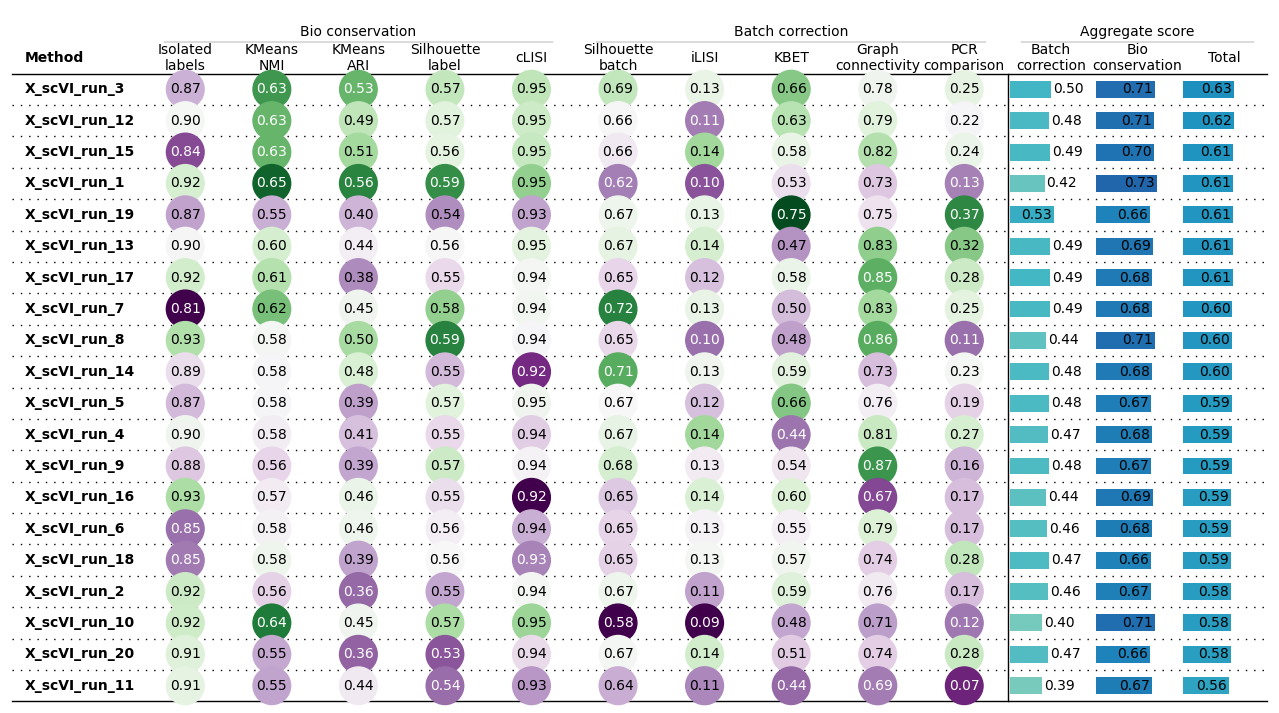

In [85]:
bm.plot_results_table(min_max_scale=False)

In [86]:
# best_model.save(dir_path = "./saved_best_model_v2", overwrite=True, save_anndata=True)